## Import packages and Load dataset

In [42]:
# chnage directory
path = "C:\\Users\\sin\\Desktop\\capstone_conocoPhillips"
import os
os.chdir(path)

In [43]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats

In [44]:
#load the file
file_name =  "UT Comp_Seq.xlsx"
comseq = pd.read_excel(io = file_name, sheet_name = 0)

## Get famillar with data

### Independent features

1. Best1 Mo BOPD
2. Best3 Mo BOPD
3. Best6 Mo BOPD
4. Best9 Mo BOPD
5. Best12 Mo BOPD
6. 12 month Cum Prod

### Dependent features:
1. Formation
2. Lateral Length
3. Stages
4. Location of well (township,range,section,lat,long etc.)
5. Total proppant
6. fluid
7. Completion Type
8. Well Spacing

## Clean Data
### 1. Remove Duplicate

In [45]:
df = comseq.copy()
# check for duplicate
dpl = sum(df.duplicated())
print("There is ",  dpl,  " duplicate") # no duplicate

There is  0  duplicate


### 2. Replace Na Values in dependent variable

In [46]:
dependent = ['Best1 Mo BOPD', 'Best3 Mo BOPD', 'Best6 Mo BOPD',
       'Best9 Mo BOPD', 'Best12 Mo BOPD', '12 month Cum Prod']
df[dependent].isnull().sum()

Best1 Mo BOPD        1550
Best3 Mo BOPD        1656
Best6 Mo BOPD        2043
Best9 Mo BOPD        2464
Best12 Mo BOPD       2973
12 month Cum Prod       0
dtype: int64

#### Correlation 

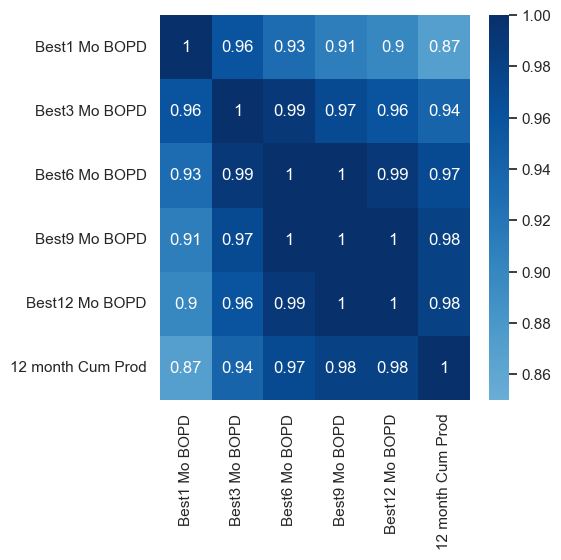

In [47]:
corr_matrix = df[dependent].corr().round(2)
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=0.85, center=.85, cmap='Blues')
plt.show()

#### Association between variablee

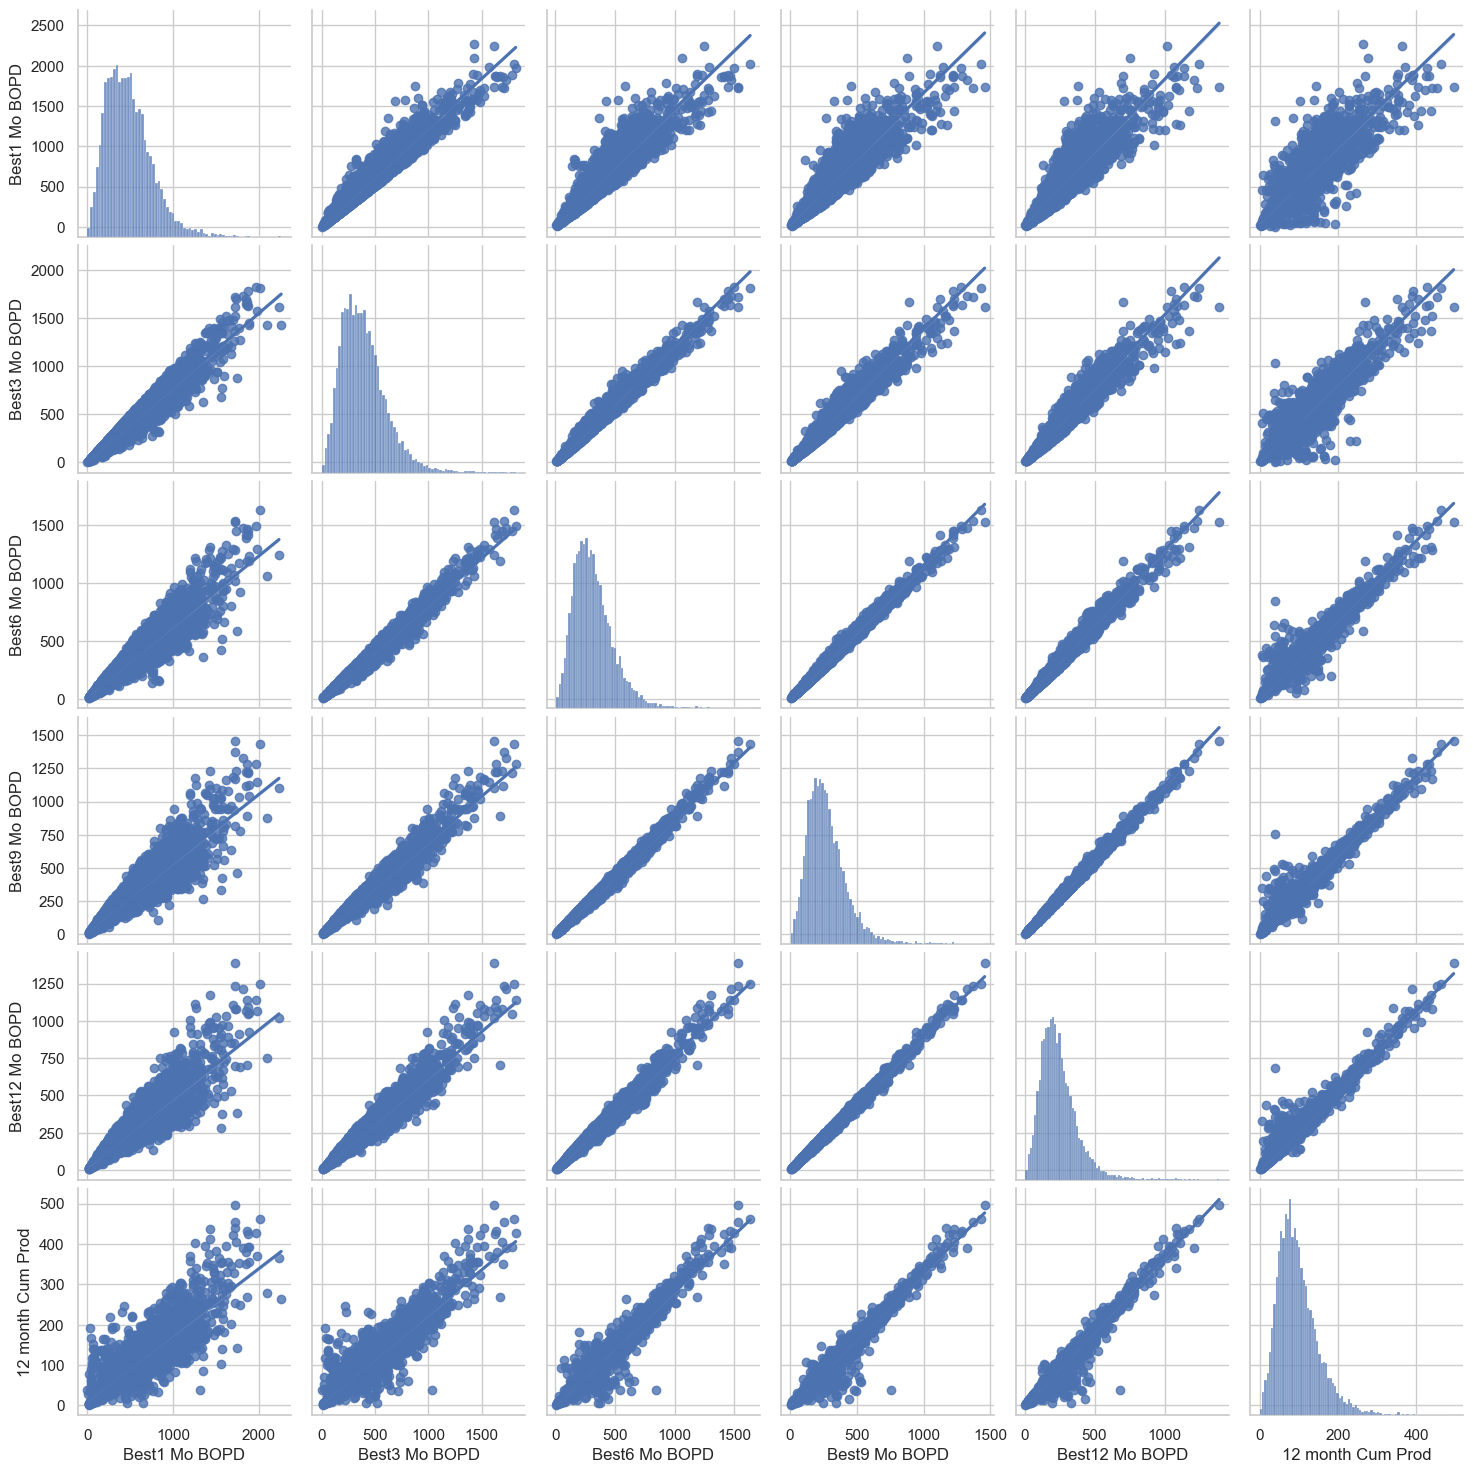

In [48]:
sns.pairplot(df[dependent], kind="reg")
plt.show()

Because of non equal varience we use Natuarl Log 

#### Association between natural logarithmic variablee

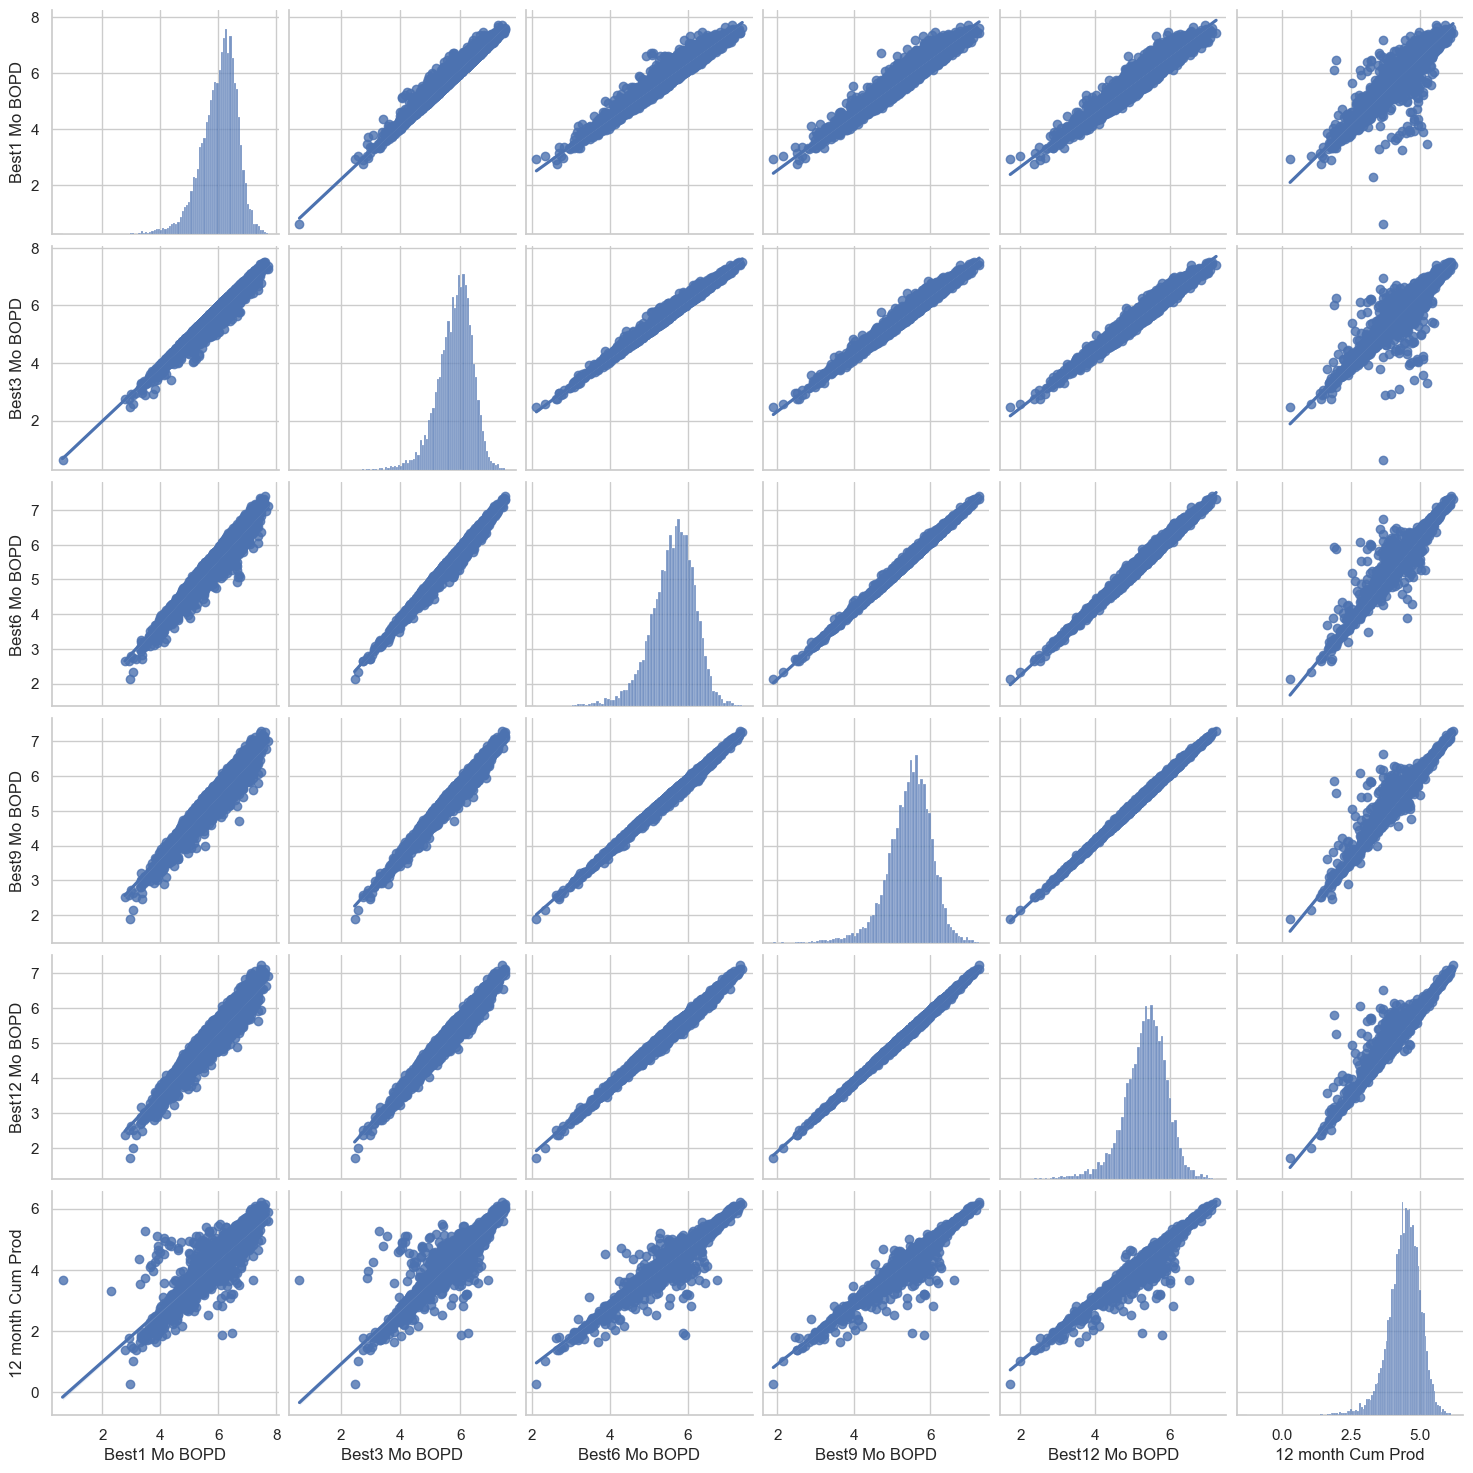

In [49]:
df_log = np.log(df[dependent])
sns.pairplot(df_log, kind="reg")
plt.show()

#### Linear models for predicting Na valuse base on highest correlated variable

In [50]:
dflog_p01 = df_log[["Best1 Mo BOPD", "Best3 Mo BOPD"]].dropna()
model01 = LinearRegression().fit(dflog_p01["Best3 Mo BOPD"].values.reshape(-1,1),
                                dflog_p01["Best1 Mo BOPD"].values.reshape(-1,1))

In [51]:
dflog_p03 = df_log[["Best3 Mo BOPD", "Best6 Mo BOPD"]].dropna()
model03 = LinearRegression().fit(dflog_p03["Best6 Mo BOPD"].values.reshape(-1,1),
                                dflog_p03["Best3 Mo BOPD"].values.reshape(-1,1))

In [52]:
dflog_p06 = df_log[["Best6 Mo BOPD", "Best9 Mo BOPD"]].dropna()
model06 = LinearRegression().fit(dflog_p06["Best9 Mo BOPD"].values.reshape(-1,1),
                                dflog_p06["Best6 Mo BOPD"].values.reshape(-1,1))

In [53]:
dflog_p09 = df_log[["Best9 Mo BOPD", "Best12 Mo BOPD"]].dropna()
model09 = LinearRegression().fit(dflog_p09["Best12 Mo BOPD"].values.reshape(-1,1),
                                dflog_p09["Best9 Mo BOPD"].values.reshape(-1,1))

In [54]:
dflog_p12 = df_log[["Best12 Mo BOPD", "12 month Cum Prod"]].dropna()
model12 = LinearRegression().fit(dflog_p12["12 month Cum Prod"].values.reshape(-1,1),
                                dflog_p12["Best12 Mo BOPD"].values.reshape(-1,1))

### Apply each model to predecit the na valuse in each specific coloumn

In [55]:
# Replace 'Best12 Mo BOPD' na values
df["pred_p12"] = np.exp(model12.predict(np.log(df["12 month Cum Prod"].values.reshape(-1,1))))
df["Best12 Mo BOPD"] = np.where(df["Best12 Mo BOPD"].isnull(),
                                df["pred_p12"],
                                df["Best12 Mo BOPD"])

In [56]:
# Replace "Best09 Mo BOPD" na values
df["pred_p9"] = np.exp(model09.predict(np.log(df["Best12 Mo BOPD"].values.reshape(-1,1))))
df["Best9 Mo BOPD"] = np.where(df["Best9 Mo BOPD"].isnull(),
                                df["pred_p9"],
                                df["Best9 Mo BOPD"])

In [57]:
# Replace "Best06 Mo BOPD" na values
df["pred_p6"] = np.exp(model06.predict(np.log(df["Best9 Mo BOPD"].values.reshape(-1,1))))
df["Best6 Mo BOPD"] = np.where(df["Best6 Mo BOPD"].isnull(),
                                df["pred_p6"],
                                df["Best6 Mo BOPD"])

In [58]:
# Replace "Best03 Mo BOPD" na values
df["pred_p3"] = np.exp(model03.predict(np.log(df["Best6 Mo BOPD"].values.reshape(-1,1))))
df["Best3 Mo BOPD"] = np.where(df["Best3 Mo BOPD"].isnull(),
                                df["pred_p3"],
                                df["Best3 Mo BOPD"])

In [59]:
# Replace "Best01 Mo BOPD" na values
df["pred_p1"] = np.exp(model01.predict(np.log(df["Best3 Mo BOPD"].values.reshape(-1,1))))
df["Best1 Mo BOPD"] = np.where(df["Best1 Mo BOPD"].isnull(),
                                df["pred_p1"],
                                df["Best1 Mo BOPD"])

In [61]:
df[dependent].isnull().sum()

Best1 Mo BOPD        0
Best3 Mo BOPD        0
Best6 Mo BOPD        0
Best9 Mo BOPD        0
Best12 Mo BOPD       0
12 month Cum Prod    0
dtype: int64

### 3. Replace Na Values in Independent variables

In [62]:
independent = ['Formation', 'Lateral Length', 'Stages', 'Township ',
               'Range', 'Section', 'Total Prop, lbs', 'Fluid, bbls',
               'Compl. Type', 'Latitude', 'Longitude', 'SPACING_CAPPED']

In [63]:
df[independent].isnull().sum()

Formation            8
Lateral Length       8
Stages             168
Township             0
Range                0
Section              0
Total Prop, lbs      0
Fluid, bbls         17
Compl. Type         90
Latitude             0
Longitude            0
SPACING_CAPPED       9
dtype: int64

In [64]:
df.dropna(subset = independent, inplace = True)
df.isnull().sum()

Operator                 0
Well Name                0
Formation                0
Lateral Length           0
Stages                   0
Township                 0
Range                    0
Section                  0
Total Prop, lbs          0
Fluid, bbls              0
Date Fracd               0
Best1 Mo BOPD            0
Best3 Mo BOPD            0
Best6 Mo BOPD            0
Best9 Mo BOPD            0
Best12 Mo BOPD           0
Compl. Type              0
Latitude                 0
Longitude                0
Fluid Type from DI    5620
SPACING_CAPPED           0
12 month Cum Prod        0
pred_p12                 0
pred_p9                  0
pred_p6                  0
pred_p3                  0
pred_p1                  0
dtype: int64

## "12 month Cum Prod"

### Check Normality of "12 month Cum Prod"

#### Histogram Plot

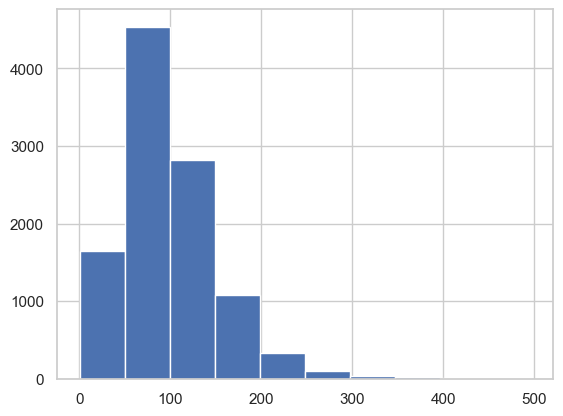

In [65]:
# histogram plot
plt.hist(df["12 month Cum Prod"])
plt.show()

#### qq-plot

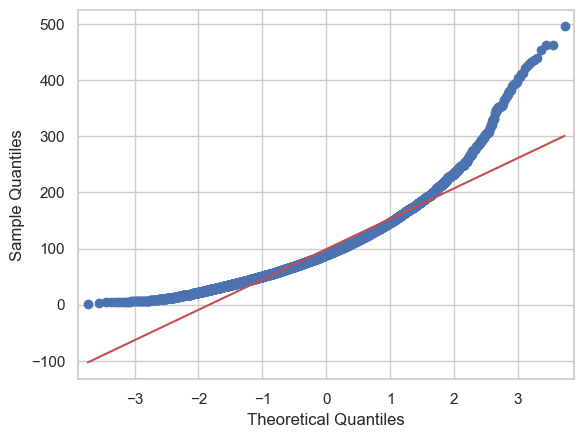

In [66]:
# QQ Plot
qqplot(df["12 month Cum Prod"], line='s')
plt.show()

#### Shapiro-Wilk Test

In [67]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(df["12 month Cum Prod"])
print(p)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

0.0
Statistics=0.914, p=0.000
Sample does not look Gaussian (reject H0)


#### D’Agostino’s K^2 Test

In [68]:
# D'Agostino and Pearson's Test


stat, p = normaltest(df["12 month Cum Prod"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=3090.900, p=0.000
Sample does not look Gaussian (reject H0)


## Check normality for logistic transformation  

In [69]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(np.log(df["12 month Cum Prod"]))
print(p)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

2.4943112664981744e-43
Statistics=0.968, p=0.000
Sample does not look Gaussian (reject H0)


In [70]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest

stat, p = normaltest(np.log(df["12 month Cum Prod"]))
print(p)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

0.0
Statistics=1591.849, p=0.000
Sample does not look Gaussian (reject H0)


## Completion type

### cleaning Completion type

In [71]:
df["completion type"] = df["Compl. Type"].str.lower()
df["completion type"] = df["completion type"].str.strip()
df["completion type"] = df["completion type"].str.replace("and" , "&")
df["completion type"] = df["completion type"].str.replace("sleeve ", "sleeves ")
df["completion type"] = np.where(df["completion type"].str.find("sleeves &") != -1, 'Hybrid Completion', df["completion type"])
df["completion type"] = np.where(df["completion type"].map(df["completion type"].value_counts()) < 100, "others", df["completion type"])
df["completion type"].value_counts()

sleeves              4205
p & p                3323
p & p (cmt.)         1494
oh                    683
no data               461
Hybrid Completion     360
others                 67
Name: completion type, dtype: int64

In [72]:
# drop rows with "No Data" value in "completion type"
df = df[df["completion type"] != "no data"]
df = df[df["completion type"] != "others"]
df["completion type"].value_counts()

sleeves              4205
p & p                3323
p & p (cmt.)         1494
oh                    683
Hybrid Completion     360
Name: completion type, dtype: int64

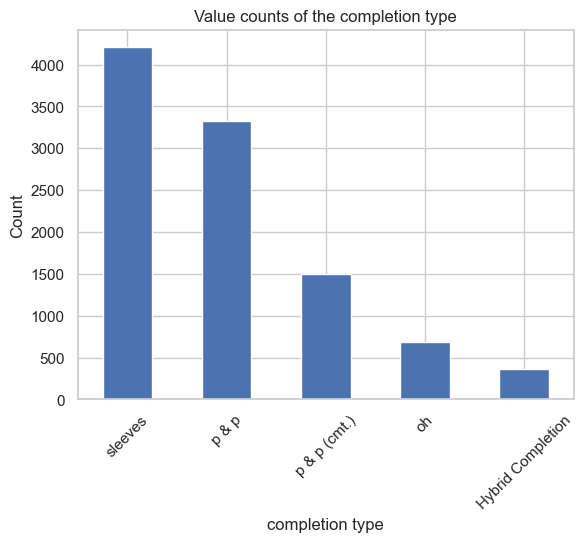

In [73]:
# bar plot again
df["completion type"].value_counts().plot(kind="bar")
plt.title("Value counts of the completion type")
plt.xlabel("completion type")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

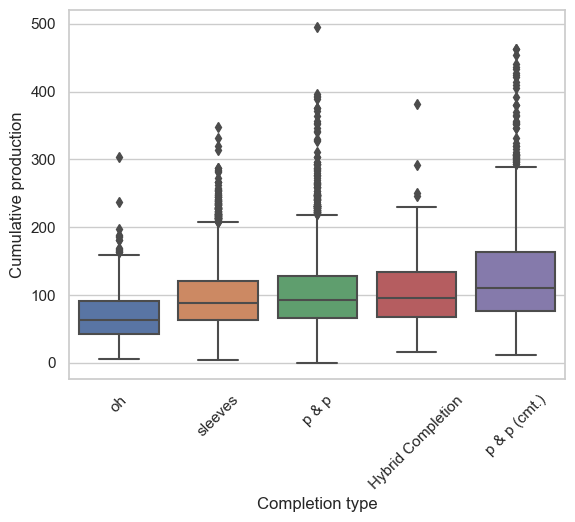

In [74]:
sns.set(style="whitegrid")
 
# Find the order
my_order = df.groupby(by=["completion type"])["12 month Cum Prod"].median().sort_values().index

# Give it to the boxplot
sns.boxplot(x = "completion type",
            y = '12 month Cum Prod',
            data = df,
            order = my_order)
plt.xticks(rotation = 45)
plt.xlabel("Completion type")
plt.ylabel("Cumulative production")
plt.show()

 ## Kruskal Wallis test

In [75]:
cum_prod_OH = df[( df["completion type"] == "oh")]["12 month Cum Prod"]
cum_prod_Sleeves = df[( df["completion type"] == "sleeves")]["12 month Cum Prod"]
cum_prod_PP = df[( df["completion type"] == "p & p")]["12 month Cum Prod"]
cum_prod_PPcmt = df[( df["completion type"] == "p & p (cmt.)")]["12 month Cum Prod"]
cum_prod_hybrid = df[( df["completion type"] == "Hybrid Completion")]["12 month Cum Prod"]

stats.kruskal(cum_prod_OH,
              cum_prod_hybrid,
             cum_prod_Sleeves,
             cum_prod_PP,
             cum_prod_PPcmt)

KruskalResult(statistic=550.3954476403669, pvalue=8.40170072820276e-118)

Since the p-value is small there is significantly difference between completion type groups. 

## One Way Anova test

In [76]:
stats.f_oneway(cum_prod_OH,
              cum_prod_hybrid,
             cum_prod_Sleeves,
             cum_prod_PP,
             cum_prod_PPcmt)

F_onewayResult(statistic=169.66679421243396, pvalue=7.781395195460722e-141)

Since the p-value is small there is significantly difference between completion type groups.

# Formation

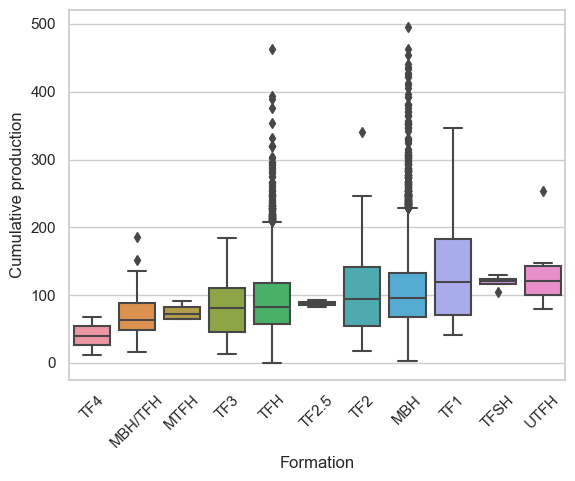

In [77]:
sns.set(style="whitegrid")
 
# Find the order
my_order = df.groupby(by=["Formation"])["12 month Cum Prod"].median().sort_values().index

# Give it to the boxplot
sns.boxplot(x = 'Formation',
            y = '12 month Cum Prod',
            data = df,
            order = my_order)
plt.xticks(rotation = 45)
plt.xlabel("Formation")
plt.ylabel("Cumulative production")
plt.show()

 ## Kruskal Wallis test

In [78]:
cum_prod_MBH = df[( df["Formation"] == "MBH")]["12 month Cum Prod"]
cum_prod_TFH = df[( df["Formation"] == "TFH")]["12 month Cum Prod"]
cum_prod_TF2 = df[( df["Formation"] == "TF2")]["12 month Cum Prod"]
cum_prod_TF3 = df[( df["Formation"] == "TF3")]["12 month Cum Prod"]
cum_prod_TF1 = df[( df["Formation"] == "TF1")]["12 month Cum Prod"]
cum_prod_MTFH = df[( df["Formation"] == "MTFH")]["12 month Cum Prod"]
cum_prod_UTFH = df[( df["Formation"] == "UTFH")]["12 month Cum Prod"]
cum_prod_TFSH = df[( df["Formation"] == "TFSH")]["12 month Cum Prod"]
cum_prod_TF4 = df[( df["Formation"] == "TF4")]["12 month Cum Prod"]
cum_prod_TF2_5 = df[( df["Formation"] == "TF2.5")]["12 month Cum Prod"]
cum_prod_MBHTFH = df[( df["Formation"] == "MBH/TFH")]["12 month Cum Prod"]


stats.kruskal(cum_prod_MBH,
              cum_prod_TFH,
              cum_prod_TF2,
              cum_prod_TF3,
              cum_prod_TF1,
              cum_prod_MTFH,
             cum_prod_UTFH,
             cum_prod_TFSH,
             cum_prod_TF4,
             cum_prod_TF2_5,
             cum_prod_MBHTFH)

KruskalResult(statistic=183.83251410616919, pvalue=3.7474724487326394e-34)

Since the p-value is small there is significantly difference between Formation groups.

### One Way Anova

In [79]:
stats.f_oneway(cum_prod_MBH,
              cum_prod_TFH,
              cum_prod_TF2,
              cum_prod_TF3,
              cum_prod_TF1,
              cum_prod_MTFH,
             cum_prod_UTFH,
             cum_prod_TFSH,
             cum_prod_TF4,
             cum_prod_TF2_5,
             cum_prod_MBHTFH)

F_onewayResult(statistic=16.35562341075451, pvalue=1.0830912166027914e-29)

Since the p-value is small there is significantly difference between Formation groups.

# Loacation

## Compare production in different time interval

In [80]:
def plotMapWells(c):
    fig = df.plot(kind="scatter",
              x="Longitude",
              y="Latitude",
              figsize=(10,7),
              label= c,
              c=c,
              cmap=plt.get_cmap("jet"),
              colorbar=True,
              alpha=0.4)

    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)
    plt.legend(fontsize=16)
    plt.show()

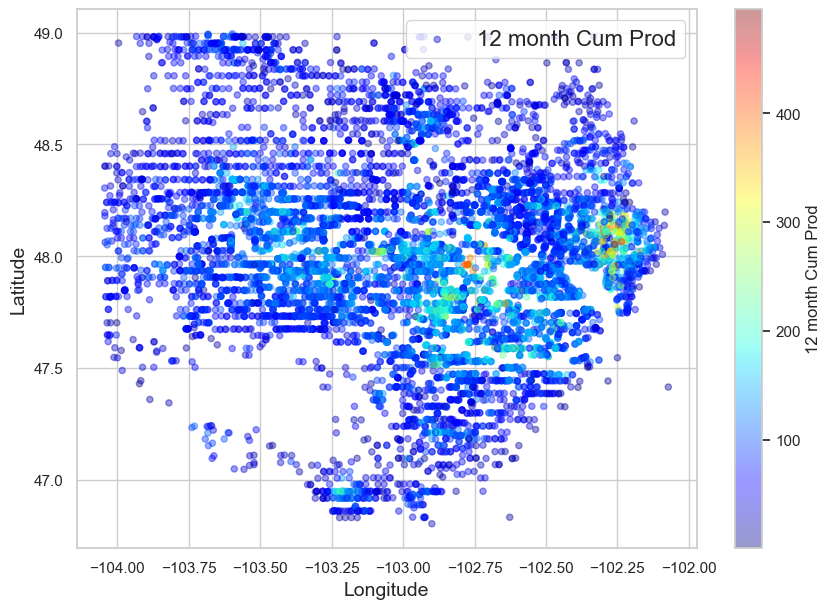

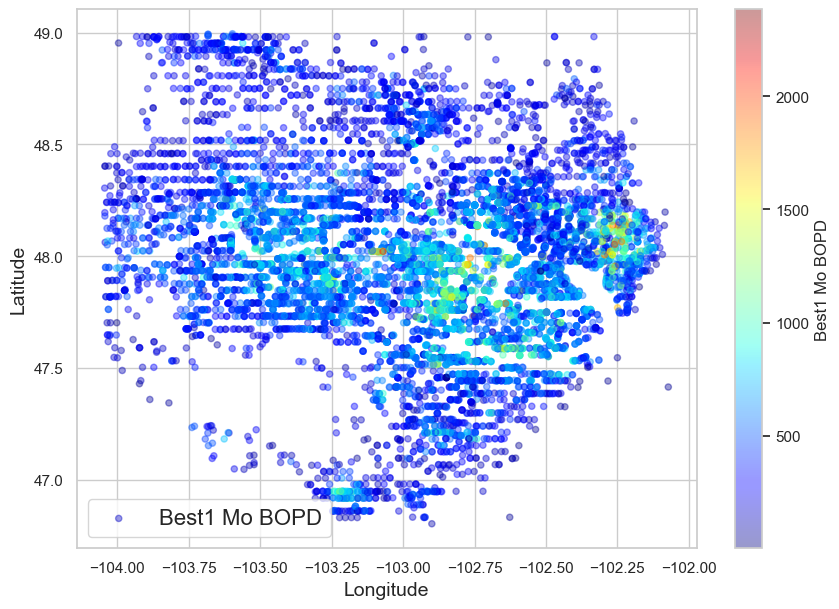

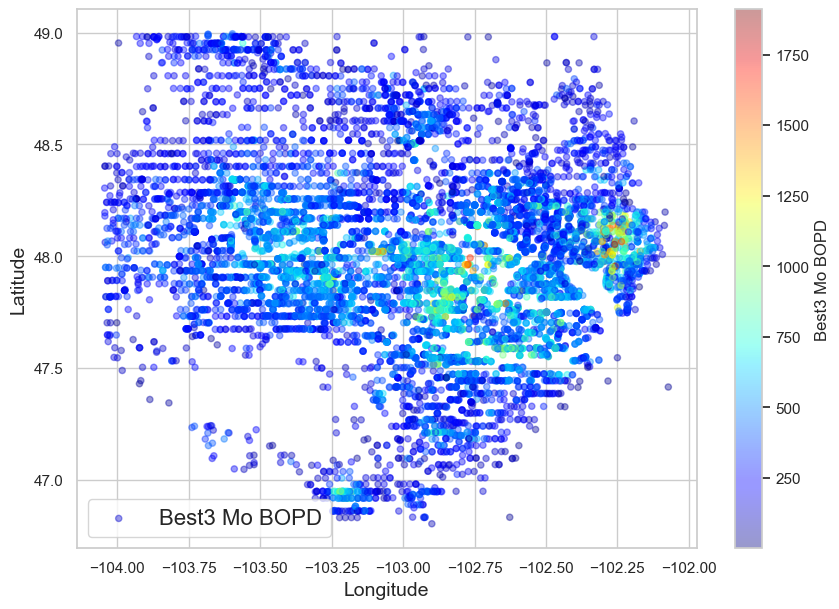

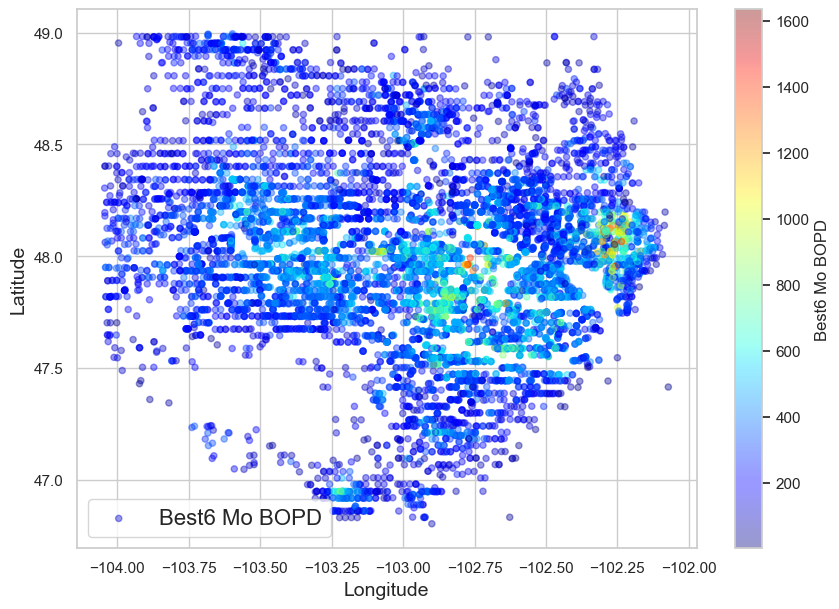

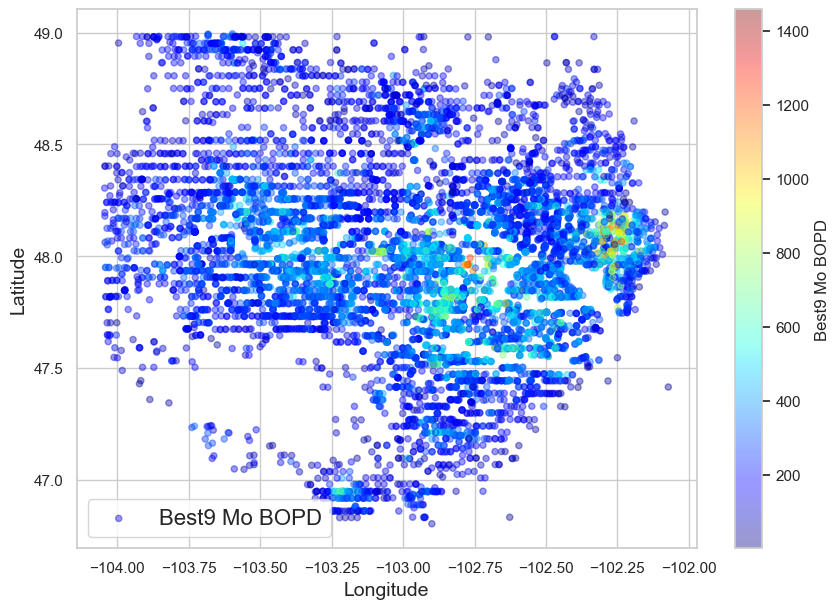

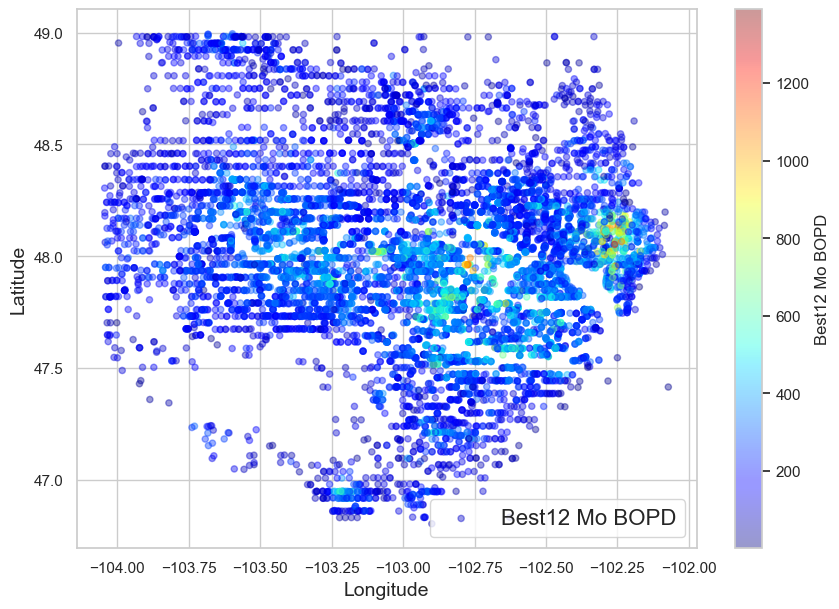

In [81]:
plotMapWells("12 month Cum Prod")
plotMapWells("Best1 Mo BOPD")
plotMapWells("Best3 Mo BOPD")
plotMapWells("Best6 Mo BOPD")
plotMapWells("Best9 Mo BOPD")
plotMapWells("Best12 Mo BOPD")

# Township

In [82]:
df["Township "].unique()

array([143, 160, 142, 152, 156, 147, 146, 144, 148, 145, 149, 153, 151,
       150, 155, 139, 154, 159, 161, 157, 158, 141, 140, 162, 163, 164],
      dtype=int64)

In [83]:
df.groupby(by=["Township "])["12 month Cum Prod"].mean().nlargest(5)

Township 
152    126.060362
150    125.483123
153    120.189388
147    118.507046
151    117.143152
Name: 12 month Cum Prod, dtype: float64

In [84]:
df.groupby(by=["Township "])["Best1 Mo BOPD"].mean().nlargest(5)

Township 
152    680.811784
150    665.105728
147    626.626707
151    615.469740
153    606.356156
Name: Best1 Mo BOPD, dtype: float64

In [85]:
df.groupby(by=["Township "])["Best3 Mo BOPD"].mean().nlargest(5)

Township 
152    546.220270
150    538.717744
151    499.430588
147    495.462915
153    492.551216
Name: Best3 Mo BOPD, dtype: float64

In [86]:
df.groupby(by=["Township "])["Best6 Mo BOPD"].mean().nlargest(5)

Township 
152    443.950030
150    441.794478
151    410.380056
153    409.984319
147    408.058934
Name: Best6 Mo BOPD, dtype: float64

In [87]:
df.groupby(by=["Township "])["Best9 Mo BOPD"].mean().nlargest(5)

Township 
152    380.917848
150    378.467990
153    360.212620
151    354.289282
147    352.461644
Name: Best9 Mo BOPD, dtype: float64

In [88]:
df.groupby(by=["Township "])["Best12 Mo BOPD"].mean().nlargest(5)

Township 
152    338.189448
150    336.026464
153    322.249839
151    314.955507
147    314.896538
Name: Best12 Mo BOPD, dtype: float64

In [89]:
df.groupby(by=["Township "])["Best12 Mo BOPD"].mean().nlargest(5)

Township 
152    338.189448
150    336.026464
153    322.249839
151    314.955507
147    314.896538
Name: Best12 Mo BOPD, dtype: float64

152, 150, 153, 151, 147 are the highest Township categories.

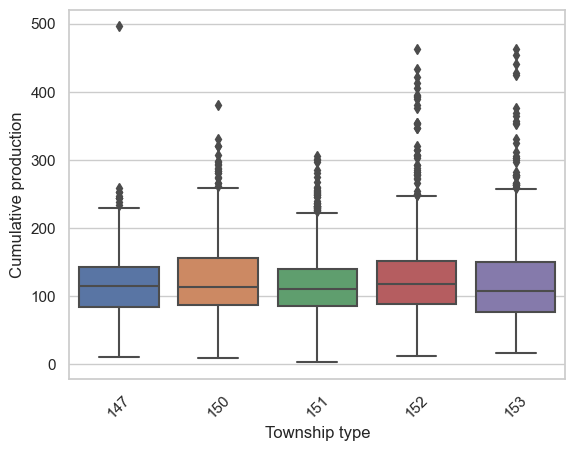

In [90]:
sns.set(style="whitegrid")
 
# Find the order
list_top5_township = [152, 150, 153, 151, 147]
df_top5_township = df[df["Township "].isin(list_top5_township)]
# Give it to the boxplot
sns.boxplot(x = 'Township ',
            y = '12 month Cum Prod',
            data = df_top5_township)

plt.xticks(rotation = 45)
plt.xlabel("Township type")
plt.ylabel("Cumulative production")
plt.show()

# Define new varables

In [93]:
df["frac_design"] = df["Total Prop, lbs"]/ (df["Fluid, bbls"] * 42)
df["stage_length"] = df["Lateral Length"]/ df["Stages"]

In [94]:
# replce inf values with 0
df["frac_design"] = np.where(df["Fluid, bbls"] == 0, 0, df["Fluid, bbls"])

## apply  pycaret for the best model

In [95]:
df.columns

Index(['Operator', 'Well Name', 'Formation', 'Lateral Length', 'Stages',
       'Township ', 'Range', 'Section', 'Total Prop, lbs', 'Fluid, bbls',
       'Date Fracd', 'Best1 Mo BOPD', 'Best3 Mo BOPD', 'Best6 Mo BOPD',
       'Best9 Mo BOPD', 'Best12 Mo BOPD', 'Compl. Type', 'Latitude',
       'Longitude', 'Fluid Type from DI', 'SPACING_CAPPED',
       '12 month Cum Prod', 'pred_p12', 'pred_p9', 'pred_p6', 'pred_p3',
       'pred_p1', 'completion type', 'frac_design', 'stage_length'],
      dtype='object')

In [96]:
features = ['Formation', 'Lateral Length', 'Stages', 'Township ', 'Range', 'Section',
            'Total Prop, lbs', 'Fluid, bbls', 'completion type', 'Latitude', 'Longitude',
            'SPACING_CAPPED', '12 month Cum Prod', 'frac_design', 'stage_length']
dataset1 = df[features]

In [97]:
#train test split for pycaret:
df_train = dataset1.sample(frac=0.7, random_state=786)
df_test = dataset1.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_test.shape))

Data for Modeling: (7046, 15)
Unseen Data For Predictions: (3019, 15)


In [98]:
df_train.head()

Formation  Lateral Length  Stages  Township   Range  Section  \
0       MBH          9030.0    22.0        153     93       25   
1       MBH          4955.0    20.0        160     91       36   
2       TFH         10028.0    30.0        152    104       36   
3       MBH         10011.0    30.0        155     97       21   
4       TFH         12029.0    36.0        150     91       31   

   Total Prop, lbs  Fluid, bbls completion type   Latitude   Longitude  \
0        2299700.0      28277.0         sleeves  48.038945 -102.584463   
1        1857858.0      18072.0              oh  48.647027 -102.384156   
2        5552623.0     206712.0           p & p  47.948534 -103.941330   
3        3474340.0     195598.0           p & p  48.227534 -103.170343   
4        3077245.0      55080.0         sleeves  47.761432 -102.365600   

   SPACING_CAPPED  12 month Cum Prod  frac_design  stage_length  
0       660.00000              92.49      28277.0    410.454545  
1       660.00000              23.73      18072.0    247.750000  
2       110.31869              38.50     206712.0    334.266667  
3       646.99060             116.26     195598.0    333.700000  
4       660.00000             118.84      55080.0    334.138889

In [104]:
from pycaret.regression import *
exp_reg101 = setup(data = df_train,
                   target = '12 month Cum Prod',
                   session_id=123,
                   transformation = True,
                   transform_target = True,
                   combine_rare_levels = True,
                   #data_split_shuffle=True,
                   rare_level_threshold = 0.05,
                   remove_multicollinearity = True,
                   multicollinearity_threshold = 0.95) 


IntProgress(value=0, description='Processing: ', max=3)

Initiated  . . . . . . . . . . . . . . . . . .                     09:51:41
Status     . . . . . . . . . . . . . . . . . .  Preparing Data for Modeling

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.